In [3]:
!pip install torchmetrics

     |████████████████████████████████| 329 kB 12.3 MB/s 


In [4]:
!pip install pytorch

  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-erayh6od/pytorch_31b019300c114f1db2ed28295d920db3/setup.py'"'"'; __file__='"'"'/tmp/pip-install-erayh6od/pytorch_31b019300c114f1db2ed28295d920db3/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-tvl_swdy/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/pytorch Check the logs for full command output.


In [5]:
!pip install ipdb

     |████████████████████████████████| 791 kB 13.5 MB/s 
     |████████████████████████████████| 374 kB 47.3 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=3c508e2923ee83fc276ce0fb492878235fe13ba6adb2493b32b88ddb81e35e80
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit

In [6]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
from torchmetrics.functional import precision, accuracy
import ipdb

get data

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [8]:
import pandas as pd
# import numpy as np
from string import punctuation
from collections import Counter


In [9]:
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import ipdb

data to df

positive tone = 1

negative tone = 0

In [10]:
with open('/content/drive/My Drive/positive.csv') as f:
    pos_tweets = pd.read_csv(f, encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])

In [11]:
with open('/content/drive/My Drive/negative.csv') as f:
    neg_tweets = pd.read_csv(f, encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )

neg_tweets['tone'] = 0

In [12]:
all_tweets_data = pos_tweets.append(neg_tweets)
print(len(all_tweets_data))

226834


In [13]:
tweets_data = all_tweets_data[['text','tone']]

In [14]:
tweets_data.tone.unique()

array([1, 0])

делим на трейн и тест

In [15]:
train_data, val_data = train_test_split(tweets_data, test_size=0.2)

все уникальные слова в словарь

фильтр по количеству упоминаний

препроцессинг версия 1 - минимальный

In [16]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [17]:
vocab = Counter() # для ВСЕХ ДАННЫХ

for text in tweets_data['text']:
    vocab.update(preprocess(text))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 366250


In [18]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 2 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 2 раз: 64423


In [19]:
#создаем словарь с индексами word2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [20]:
import json

# with open('/content/drive/My Drive/word2id.json', 'w') as f:
#     json.dump(word2id, f)

In [21]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [ ]:
# with open('/content/drive/My Drive/id2word.json', 'w') as f:
#     json.dump(id2word, f)

id2w from gdrive

In [ ]:
with open('/content/drive/My Drive/id2word.json') as f:
    id2word = json.load(f)

w2id from gdrive 

In [ ]:
with open('/content/drive/My Drive/word2id.json') as f:
    word2id = json.load(f)

In [22]:
import torch
# print(torch.__version__)

In [23]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE


device(type='cuda')

датасет

In [24]:
from string import punctuation

In [ ]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, punctuation, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.punctuation = punctuation
        self.device = DEVICE

    def __len__(self):
        return self.length
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(self.punctuation) for token in tokens]
        return tokens

    def __getitem__(self, index): 
        sentence = self.dataset[index] # '@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)'
        preproced = self.preprocess(sentence)
        ids = torch.LongTensor([self.word2id[word] for word in preproced if word in self.word2id]) 
        
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

## ТРЕЙН

семплер и лоадер

In [ ]:
train_dataset = TweetsDataset(train_data, word2id, punctuation, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

## ТЕСТ

In [ ]:

val_dataset = TweetsDataset(val_data, word2id, punctuation, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [ ]:
next(iter(val_iterator))[0].shape

torch.Size([1024, 27])

две архитектуры, для каждой посчитайте **accuracy, precision, recall**

# **1** CNN model

CNN на уровне слов: 

модель берет слова, пропускает их через Embedding слой. 

По эмбеддингам проходит CNN c фильтрами с разным окном, полученные результаты конкатенируются друг с другом по глубине, 

по результату конкатенации еще один сверточный слой, 

далее max pooling over time, на выходе линейный слой + сигмоида, функция потерь BCELoss. 


(модель аналогична тому, что мы делали на паре по сверткам, но на уровне слов, а не символов)


MODEL

In [ ]:
class CNN_without_dropout(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # initializing layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim) 
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same') # 100 фильтров с окном 2
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same') # 80 фильтров с окном 3
        self.feature_bigrams = nn.Conv1d(in_channels=180, out_channels=80, kernel_size=2, padding='same') # 80 фильтров с окном 2
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2) 
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=80, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word) # модель берет слова, пропускает их через Embedding слой.
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.relu(self.trigrams(embedded))
        #batch_size x filter_count3 x seq_len*

        # полученные результаты конкатенируются друг с другом по глубине
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1) # #batch_size(длина) x filter_count3(глубина) x seq_len*(ширина)
        # batch _size x (filter_count2 + filter_count3) x seq_len*
        
        # по результату конкатенации еще один сверточный слой
        another_feature_map = self.relu(self.feature_bigrams(concat))
        #batch_size x filter_count4 x seq_len* 

        # далее max pooling over time
        pooling_overtime = another_feature_map.max(2)[0] # max pooling over time
        # batch_size x filter_count4

        logits = self.hidden(pooling_overtime) # лин слой 
        logits = self.out(logits) # sigmoid 
        return logits

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # initializing layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim) 
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same') # 100 фильтров с окном 2
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same') # 80 фильтров с окном 3
        self.feature_bigrams = nn.Conv1d(in_channels=180, out_channels=80, kernel_size=2, padding='same') # 80 фильтров с окном 2
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2) 
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=80, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word) # модель берет слова, пропускает их через Embedding слой.
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))
        #batch_size x filter_count3 x seq_len*

        # полученные результаты конкатенируются друг с другом по глубине
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1) # #batch_size(длина) x filter_count3(глубина) x seq_len*(ширина)
        # batch _size x (filter_count2 + filter_count3) x seq_len*
        
        # по результату конкатенации еще один сверточный слой
        another_feature_map = self.dropout(self.relu(self.feature_bigrams(concat)))
        #batch_size x filter_count4 x seq_len* 

        # далее max pooling over time
        pooling_overtime = another_feature_map.max(2)[0] # max pooling over time
        # batch_size x filter_count4

        logits = self.hidden(pooling_overtime) # лин слой 
        logits = self.out(logits) # sigmoid 
        return logits

## TRAINING

За одну эпоху нам надо для каждого батча:

-- применить к нему модель,

-- посчитать значение функции потерь,

-- посчитать градиенты,

-- обновить веса (параметры модели)

In [25]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        try:
            text = texts[0].to(DEVICE)
            symbs = texts[1].to(DEVICE)
            preds = model((text, symbs))
        except:
            preds = model(texts.to(DEVICE))
        
        preds = model((text, symbs))
        loss = criterion(preds, ys.to(DEVICE)) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [26]:
def evaluate(model, iterator, criterion):
    epoch_loss = []
    epoch_metric = []

    epoch_precision = []
    epoch_recall = []
    epoch_accuracy = []
    
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            
            try:
                text = texts[0].to(DEVICE)
                symbs = texts[1].to(DEVICE)
                preds = model((text, symbs))
            except:
                preds = model(texts.to(DEVICE))
            
            loss = criterion(preds, ys.to(DEVICE))
            epoch_loss.append(loss.item())

            
            # f1
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric.append(batch_metric.cpu().numpy())

            
            # precision
            batch_prec = precision(preds.round().long(), ys.long(), ignore_index=0)
            epoch_precision.append(batch_prec.cpu().numpy())
            
            # recall
            batch_recall = recall(preds.round().long(), ys.long(), ignore_index=0)
            epoch_recall.append(batch_recall.cpu().numpy())
            
            # accuracy
            batch_acc = accuracy(preds.round().long(), ys.long(), ignore_index=0)
            epoch_accuracy.append(batch_acc.cpu().numpy())
            

    return np.mean(epoch_metric), np.mean(epoch_loss), np.mean(epoch_precision), np.mean(epoch_recall), np.mean(epoch_accuracy)# возвращаем среднее значение по всей выборке

In [27]:
print(len(word2id)**0.5) # примерный размер эмбеддинга

253.81883302859936


In [28]:
def train_epochs(model, train_iterator, val_iterator, optimizer, criterion, num_epochs=5):
    losses = []
    losses_eval = []
    f1s = []
    f1s_eval = []
    pr = []
    pr_eval = []
    acc = []
    acc_eval = []
    rec = []
    rec_eval = []

    for i in range(num_epochs):
        print(f'\nstarting Epoch {i}')
        print('Training...')
        epoch_loss = train(model, train_iterator, optimizer, criterion)
        losses.append(epoch_loss)
        print('\nEvaluating on train...')

        # print(evaluate(model, train_iterator, criterion))
        f1_on_train, _, prec_on_train, rec_on_train, acc_on_train = evaluate(model, train_iterator, criterion)

        f1s.append(f1_on_train)
        pr.append(prec_on_train)
        rec.append(rec_on_train)
        acc.append(acc_on_train)

        print('\nEvaluating on test...')
        f1_on_test, epoch_loss_on_test, prec_on_test, rec_on_test, acc_on_test = evaluate(model, val_iterator, criterion)
        losses_eval.append(epoch_loss_on_test)
        f1s_eval.append(f1_on_test)
        pr_eval.append(prec_on_test)
        rec_eval.append(rec_on_test)
        acc_eval.append(acc_on_test)
    
    
    return losses, losses_eval, f1s, f1s_eval, pr, pr_eval, acc, acc_eval, rec, rec_eval

In [29]:
import matplotlib.pyplot as plt

def make_graphs(losses, losses_eval, 
                f1s, f1s_eval, 
                pr, pr_eval, 
                acc, acc_eval, 
                rec, rec_eval):

  plt.plot(losses)
  plt.plot(losses_eval)
  plt.title('BCE loss value')
  plt.ylabel('BCE loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

  plt.plot(f1s)
  plt.plot(f1s_eval)
  plt.title('f1 value')
  plt.ylabel('f1 value')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

  plt.plot(pr)
  plt.plot(pr_eval)
  plt.title('Precision')
  plt.ylabel('Precision')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

  plt.plot(rec)
  plt.plot(rec_eval)
  plt.title('Recall')
  plt.ylabel('Recall')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

  plt.plot(acc)
  plt.plot(acc_eval)
  plt.title('Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()


In [30]:
def add_to_table(losses_eval, pr_eval, rec_eval, acc_eval, f1s_eval, all_dfs):
    """
    add mean metrics from last 2 epochs on test to summary table
    """

    all_metrics = []

    stroka = {}
    stroka['losses'] = np.mean(losses_eval[-2:])
    stroka['precision'] = np.mean(pr_eval[-2:])
    stroka['recall'] = np.mean(rec_eval[-2:])
    stroka['accuracy'] = np.mean(acc_eval[-2:])
    stroka['f1'] = np.mean(f1s_eval[-2:])
    all_metrics.append(stroka) # list of dicts

    all_dfs.append(pd.DataFrame(all_metrics))



starting Epoch 0
Training...
Train loss: 0.6659481823444366
Train loss: 0.634675169336623
Train loss: 0.6173190485972625
Train loss: 0.6047975446680467
Train loss: 0.5947347478619938

Evaluating on train...

Evaluating on test...

starting Epoch 1
Training...
Train loss: 0.524587680311764
Train loss: 0.5116138380506764
Train loss: 0.5063374801897086
Train loss: 0.5020413812544706
Train loss: 0.49735402992402

Evaluating on train...

Evaluating on test...

starting Epoch 2
Training...
Train loss: 0.4362983852624893
Train loss: 0.43028327131616895
Train loss: 0.4267672902116409
Train loss: 0.4252690404867954
Train loss: 0.4243321166983966

Evaluating on train...

Evaluating on test...

starting Epoch 3
Training...
Train loss: 0.36884188126115236
Train loss: 0.36506981780563574
Train loss: 0.36151088344363064
Train loss: 0.3591731340765095
Train loss: 0.3578798078942573

Evaluating on train...

Evaluating on test...

starting Epoch 4
Training...
Train loss: 0.29238788345280814
Train loss

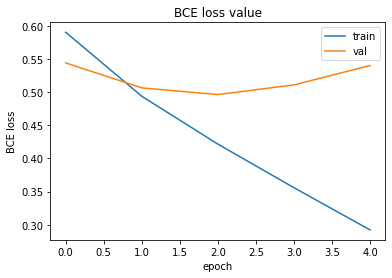

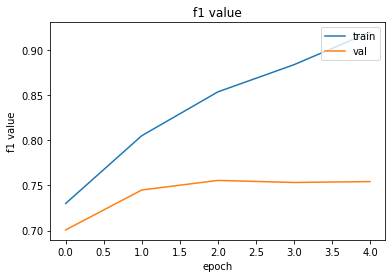

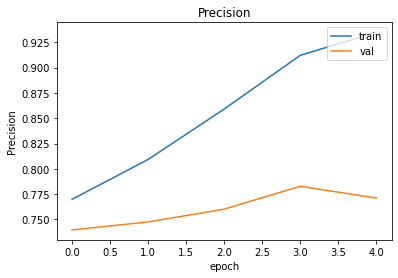

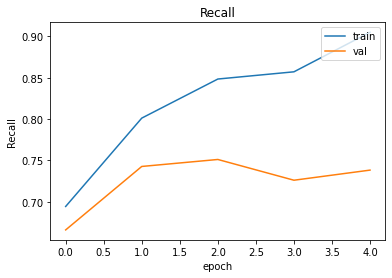

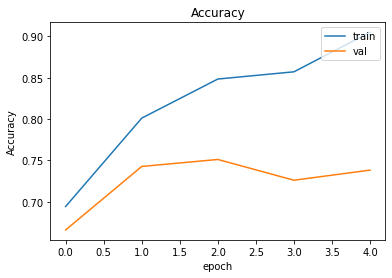

In [ ]:
model = CNN_without_dropout(len(word2id), 250)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)
num_epochs = 5

losses, losses_eval, f1s, f1s_eval, pr, pr_eval, acc, acc_eval, rec, rec_eval = train_epochs(model, 
                                                                                             train_iterator, 
                                                                                             val_iterator, 
                                                                                             optimizer,
                                                                                             criterion,
                                                                                             num_epochs)
make_graphs(losses, losses_eval, 
                f1s, f1s_eval, 
                pr, pr_eval, 
                acc, acc_eval, 
                rec, rec_eval)

In [ ]:
alldf1 = []

add_to_table(losses_eval, pr_eval, rec_eval, acc_eval, f1s_eval, alldf1)

In [ ]:
alldf1[0].head()

,losses,precision,recall,accuracy,f1
0,0.525789,0.776972,0.73223,0.73223,0.753772


видно, что модель достаточно сильно переобучается. добавлю дропаут


starting Epoch 0
Training...
Train loss: 0.7006936932311338
Train loss: 0.6662981026414512
Train loss: 0.6495370543920077
Train loss: 0.6372144346614536
Train loss: 0.6278140185208156

Evaluating on train...

Evaluating on test...

starting Epoch 1
Training...
Train loss: 0.5765845442519468
Train loss: 0.5654484681461168
Train loss: 0.5590563531105335
Train loss: 0.5532708759788129
Train loss: 0.5481073450425575

Evaluating on train...

Evaluating on test...

starting Epoch 2
Training...
Train loss: 0.5090961175806382
Train loss: 0.5006333468616873
Train loss: 0.4966152086853981
Train loss: 0.49500835370674406
Train loss: 0.49205295878580246

Evaluating on train...

Evaluating on test...

starting Epoch 3
Training...
Train loss: 0.45601926305714774
Train loss: 0.4510333581247192
Train loss: 0.44932565236320865
Train loss: 0.4482265466408764
Train loss: 0.44634151972573377

Evaluating on train...

Evaluating on test...

starting Epoch 4
Training...
Train loss: 0.4173682673889048
Train 

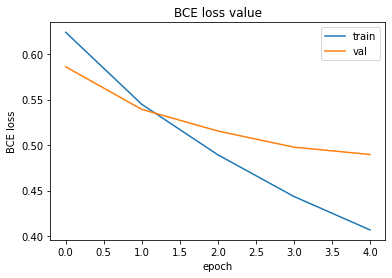

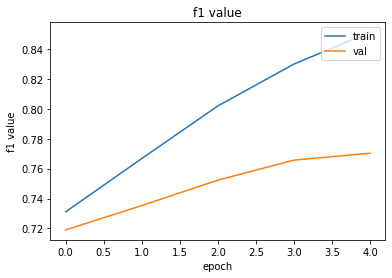

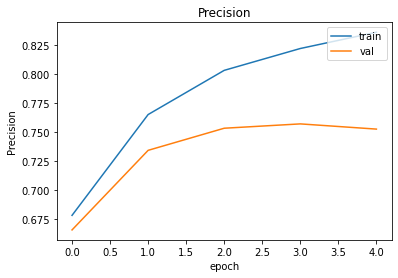

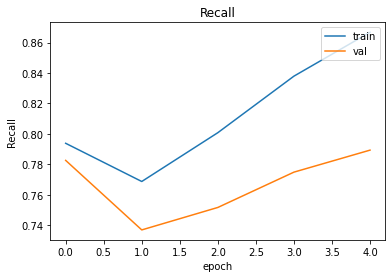

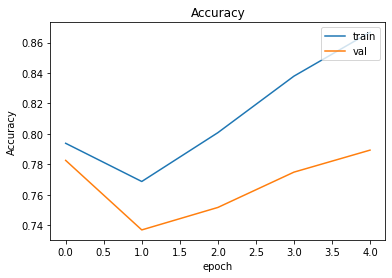

In [ ]:
model = CNN(len(word2id), 250)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)
num_epochs = 5

losses, losses_eval, f1s, f1s_eval, pr, pr_eval, acc, acc_eval, rec, rec_eval = train_epochs(model, 
                                                                                             train_iterator, 
                                                                                             val_iterator, 
                                                                                             optimizer,
                                                                                             criterion,
                                                                                             num_epochs)
make_graphs(losses, losses_eval, 
                f1s, f1s_eval, 
                pr, pr_eval, 
                acc, acc_eval, 
                rec, rec_eval)

In [ ]:
all_dfs = []

In [ ]:
add_to_table(losses_eval, pr_eval, rec_eval, acc_eval, f1s_eval, all_dfs)

In [ ]:
all_dfs[0].head()

,losses,precision,recall,accuracy,f1
0,0.4937,0.754757,0.78209,0.78209,0.767982


если сравнить с результатами без дропаута

In [ ]:
alldf1[0].head()

,losses,precision,recall,accuracy,f1
0,0.525789,0.776972,0.73223,0.73223,0.753772


пресижн стал немного хуже, но в целом все улучшилось

# далее эксперименты как можно улучшить резы модели с дропаутом

## эксперимент: увеличить кол-во эпох до 10


starting Epoch 0
Training...
Train loss: 0.7086196103516746
Train loss: 0.6737452469010284
Train loss: 0.656328905087251
Train loss: 0.6441195384203959
Train loss: 0.634781790533285

Evaluating on train...

Evaluating on test...

starting Epoch 1
Training...
Train loss: 0.5865674387006199
Train loss: 0.5743359759234
Train loss: 0.5654341108523883
Train loss: 0.5605572269117232
Train loss: 0.5551473614813267

Evaluating on train...

Evaluating on test...

starting Epoch 2
Training...
Train loss: 0.5170846388620489
Train loss: 0.5072469007277834
Train loss: 0.5016331228499229
Train loss: 0.4983465660819047
Train loss: 0.49504268409191876

Evaluating on train...

Evaluating on test...

starting Epoch 3
Training...
Train loss: 0.4616459371412502
Train loss: 0.4566409959309343
Train loss: 0.4515325954327217
Train loss: 0.4489695541292643
Train loss: 0.4480438254687978

Evaluating on train...

Evaluating on test...

starting Epoch 4
Training...
Train loss: 0.41452275304233327
Train loss: 0.

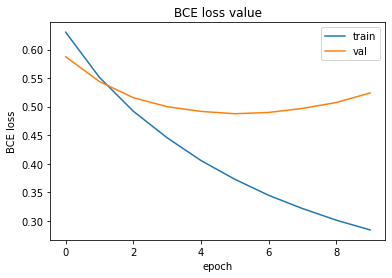

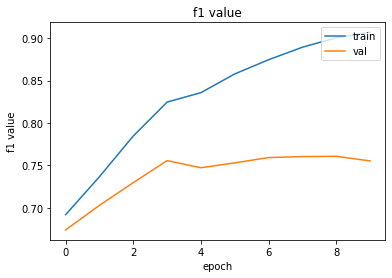

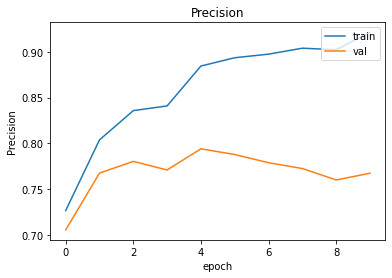

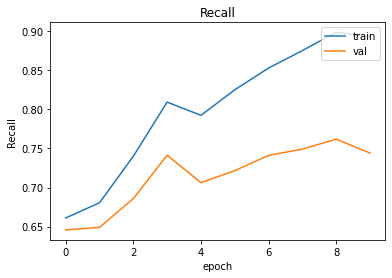

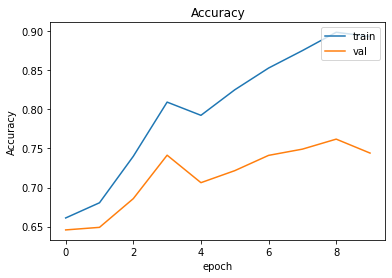

In [ ]:
model = CNN(len(word2id), 250)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)
num_epochs = 10

losses, losses_eval, f1s, f1s_eval, pr, pr_eval, acc, acc_eval, rec, rec_eval = train_epochs(model, 
                                                                                             train_iterator, 
                                                                                             val_iterator, 
                                                                                             optimizer,
                                                                                             criterion,
                                                                                             num_epochs)
make_graphs(losses, losses_eval, 
                f1s, f1s_eval, 
                pr, pr_eval, 
                acc, acc_eval,
                rec, rec_eval)

различия с вариантом с 5 эпохами небольшие, но losses, recall и f1 ухудшились

In [ ]:
add_to_table(losses_eval, pr_eval, rec_eval, acc_eval, f1s_eval, all_dfs)
pd.concat(all_dfs, axis=0)

,losses,precision,recall,accuracy,f1
0,0.493700,0.754757,0.78209,0.78209,0.767982
0,0.515575,0.763775,0.75304,0.75304,0.758115


## эксперимент: 10 эпох уменьшить лернинг рейт: было lr=0.001, стало lr=0.0001


starting Epoch 0
Training...
Train loss: 0.7406817131182727
Train loss: 0.7157214966373168
Train loss: 0.7056506379292562
Train loss: 0.698074445878859
Train loss: 0.6912264296378212

Evaluating on train...

Evaluating on test...

starting Epoch 1
Training...
Train loss: 0.6751980430939618
Train loss: 0.6606842961864196
Train loss: 0.6546202324903928
Train loss: 0.6507895696077416
Train loss: 0.64744281905821

Evaluating on train...

Evaluating on test...

starting Epoch 2
Training...
Train loss: 0.6459014222902411
Train loss: 0.636003309401913
Train loss: 0.632871344112433
Train loss: 0.6302681929773564
Train loss: 0.6282184199355114

Evaluating on train...

Evaluating on test...

starting Epoch 3
Training...
Train loss: 0.6342738323351916
Train loss: 0.6219753674838854
Train loss: 0.6181845166362249
Train loss: 0.6161571509546513
Train loss: 0.6141855819471951

Evaluating on train...

Evaluating on test...

starting Epoch 4
Training...
Train loss: 0.6184340908246881
Train loss: 0.60

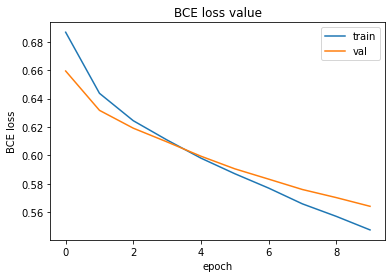

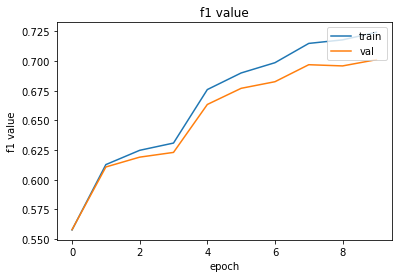

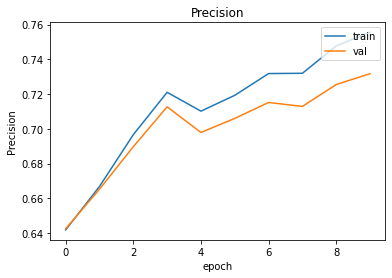

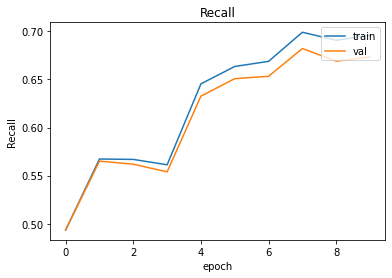

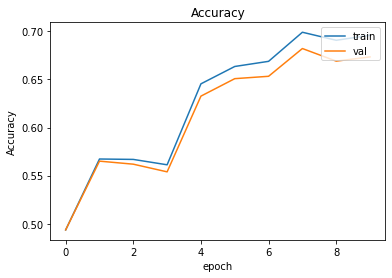

In [ ]:
model = CNN(len(word2id), 250)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)
num_epochs = 10

losses, losses_eval, f1s, f1s_eval, pr, pr_eval, acc, acc_eval, rec, rec_eval = train_epochs(model, 
                                                                                             train_iterator, 
                                                                                             val_iterator, 
                                                                                             optimizer,
                                                                                             criterion,
                                                                                             num_epochs)
make_graphs(losses, losses_eval, 
                f1s, f1s_eval, 
                pr, pr_eval, 
                acc, acc_eval,
                rec, rec_eval)

пока что этот эксперимент показал худшие результаты из всех

In [ ]:
add_to_table(losses_eval, pr_eval, rec_eval, acc_eval, f1s_eval, all_dfs)
pd.concat(all_dfs, axis=0)

,losses,precision,recall,accuracy,f1
0,0.493700,0.754757,0.782090,0.782090,0.767982
0,0.515575,0.763775,0.753040,0.753040,0.758115
0,0.567143,0.728616,0.671166,0.671166,0.698556


## эксперимент: 5 эпох, lr=0.0001


starting Epoch 0
Training...
Train loss: 0.7161469494595247
Train loss: 0.7010559050933175
Train loss: 0.6925887241959572
Train loss: 0.6851759205619208
Train loss: 0.678713126429196

Evaluating on train...

Evaluating on test...

starting Epoch 1
Training...
Train loss: 0.665510463363984
Train loss: 0.6539692498635554
Train loss: 0.6480894312262535
Train loss: 0.6450855067308
Train loss: 0.6413860225129402

Evaluating on train...

Evaluating on test...

starting Epoch 2
Training...
Train loss: 0.6468509908984689
Train loss: 0.6349891614222872
Train loss: 0.6305702340144378
Train loss: 0.6269559191285278
Train loss: 0.6242886151390514

Evaluating on train...

Evaluating on test...

starting Epoch 3
Training...
Train loss: 0.6273579527350033
Train loss: 0.617884944314542
Train loss: 0.614674833531563
Train loss: 0.612513111220847
Train loss: 0.6110148635403864

Evaluating on train...

Evaluating on test...

starting Epoch 4
Training...
Train loss: 0.6150807282503914
Train loss: 0.60707

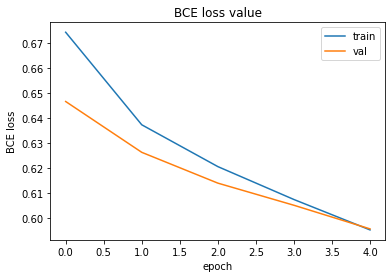

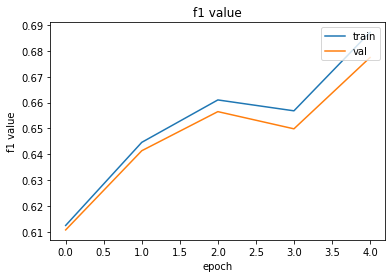

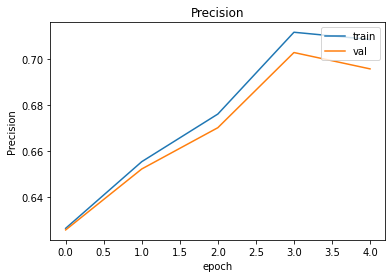

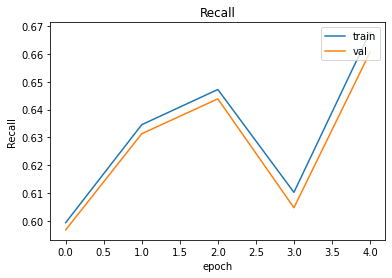

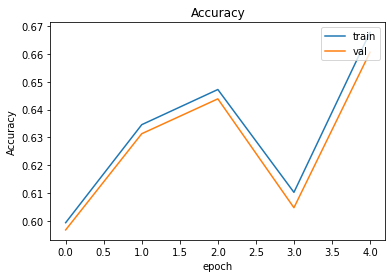

In [ ]:
model = CNN(len(word2id), 250)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)
num_epochs = 5

losses, losses_eval, f1s, f1s_eval, pr, pr_eval, acc, acc_eval, rec, rec_eval = train_epochs(model, 
                                                                                             train_iterator, 
                                                                                             val_iterator, 
                                                                                             optimizer,
                                                                                             criterion,
                                                                                             num_epochs)
make_graphs(losses, losses_eval, 
                f1s, f1s_eval, 
                pr, pr_eval, 
                acc, acc_eval,
                rec, rec_eval)

In [ ]:
add_to_table(losses_eval, pr_eval, rec_eval, acc_eval, f1s_eval, all_dfs)
pd.concat(all_dfs, axis=0)

,losses,precision,recall,accuracy,f1
0,0.493700,0.754757,0.782090,0.782090,0.767982
0,0.515575,0.763775,0.753040,0.753040,0.758115
0,0.567143,0.728616,0.671166,0.671166,0.698556
0,0.600492,0.699147,0.632695,0.632695,0.663658


итого - с маленьким lr хуже и с 5 эпохами и с 10

## эксперимент: взять предобученные эмбеддинги

### обучаю эмбеддинги на этом корпусе

In [31]:
tweets_data.text.head()

0    @first_timee хоть я и школота, но поверь, у на...
1    Да, все-таки он немного похож на него. Но мой ...
2    RT @KatiaCheh: Ну ты идиотка) я испугалась за ...
3    RT @digger2912: "Кто то в углу сидит и погибае...
4    @irina_dyshkant Вот что значит страшилка :D\nН...
Name: text, dtype: object

In [32]:
from gensim.models import FastText

texts = tweets_data.text.apply(preprocess).tolist()
model_fasttext = FastText(texts, size=250)

fasttext_weights = []
count = 0
for word in set(word2id.keys()):
    if word == 'PAD' or word == '':
        continue
    try:
        fasttext_weights.append(model_fasttext[word])
    except:
      
      count += 1
      fasttext_weights.append(np.random.normal(0,0.1,250))
    

print('num of words that arent in the fasttext model', count)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


num of words that arent in the fasttext model 49


In [ ]:
class CNN_with_pretrained(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, weights):
        super().__init__()
        # initializing layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same') # 100 фильтров с окном 2
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same') # 80 фильтров с окном 3
        self.feature_bigrams = nn.Conv1d(in_channels=180, out_channels=80, kernel_size=2, padding='same') # 80 фильтров с окном 2
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2) 
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=80, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word) # модель берет слова, пропускает их через Embedding слой.
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))
        #batch_size x filter_count3 x seq_len*

        # полученные результаты конкатенируются друг с другом по глубине
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1) # #batch_size(длина) x filter_count3(глубина) x seq_len*(ширина)
        # batch _size x (filter_count2 + filter_count3) x seq_len*
        
        # по результату конкатенации еще один сверточный слой
        another_feature_map = self.dropout(self.relu(self.feature_bigrams(concat)))
        #batch_size x filter_count4 x seq_len* 

        # далее max pooling over time
        pooling_overtime = another_feature_map.max(2)[0] # max pooling over time
        # batch_size x filter_count4

        logits = self.hidden(pooling_overtime) # лин слой 
        logits = self.out(logits) # sigmoid 
        return logits

обучение


starting Epoch 0
Training...
Train loss: 0.7134592533111572
Train loss: 0.6768812969111014
Train loss: 0.6577059299899981
Train loss: 0.6451344472898853
Train loss: 0.633955583147619

Evaluating on train...

Evaluating on test...

starting Epoch 1
Training...
Train loss: 0.5808890321675468
Train loss: 0.5674660741419032
Train loss: 0.5620023843187553
Train loss: 0.5560795737685059
Train loss: 0.5512257009402088

Evaluating on train...

Evaluating on test...

starting Epoch 2
Training...
Train loss: 0.5096065156600055
Train loss: 0.5013941232708917
Train loss: 0.49793855072214055
Train loss: 0.4945618068571571
Train loss: 0.4919976753064956

Evaluating on train...

Evaluating on test...

starting Epoch 3
Training...
Train loss: 0.45820340251221375
Train loss: 0.4506940470225569
Train loss: 0.4474811407809074
Train loss: 0.4470610817988142
Train loss: 0.4457446713557189

Evaluating on train...

Evaluating on test...

starting Epoch 4
Training...
Train loss: 0.4147101255024181
Train loss

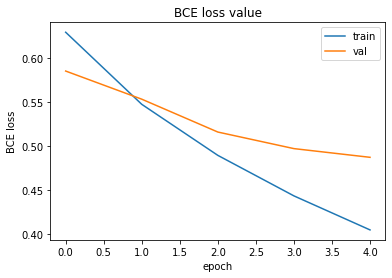

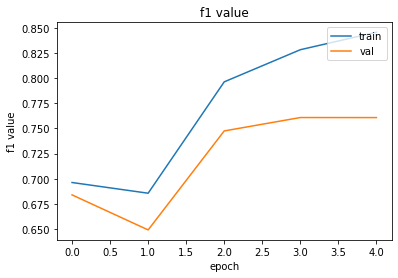

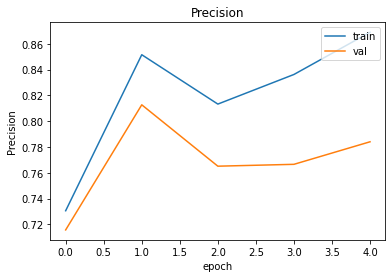

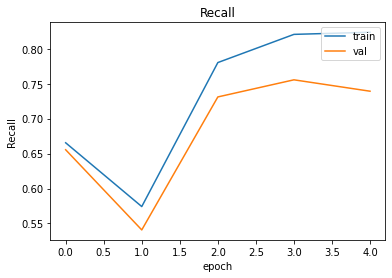

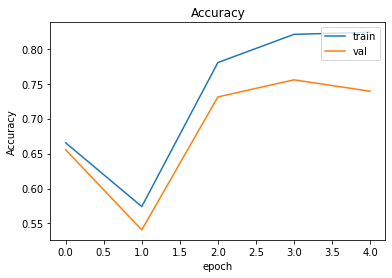

In [ ]:
model = CNN_with_pretrained(len(word2id), 250, fasttext_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


model = model.to(DEVICE)
criterion = criterion.to(DEVICE)
num_epochs = 5

losses, losses_eval, f1s, f1s_eval, pr, pr_eval, acc, acc_eval, rec, rec_eval = train_epochs(model, 
                                                                                             train_iterator, 
                                                                                             val_iterator, 
                                                                                             optimizer,
                                                                                             criterion,
                                                                                             num_epochs)
make_graphs(losses, losses_eval, 
                f1s, f1s_eval, 
                pr, pr_eval, 
                acc, acc_eval, 
                rec, rec_eval)

In [ ]:
add_to_table(losses_eval, pr_eval, rec_eval, acc_eval, f1s_eval, all_dfs)
pd.concat(all_dfs, axis=0)

,losses,precision,recall,accuracy,f1
0,0.493700,0.754757,0.782090,0.782090,0.767982
0,0.515575,0.763775,0.753040,0.753040,0.758115
0,0.567143,0.728616,0.671166,0.671166,0.698556
0,0.600492,0.699147,0.632695,0.632695,0.663658
0,0.492095,0.775303,0.747426,0.747426,0.760794


losses и precisison стали немного лучше, f1 и recall стали немного хуже.

эксперимент: уменьшить параметр дрорпаута

In [ ]:
class CNN_with_pretrained2(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, weights):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same') # 100 фильтров с окном 2
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same') # 80 фильтров с окном 3
        self.feature_bigrams = nn.Conv1d(in_channels=180, out_channels=80, kernel_size=2, padding='same') # 80 фильтров с окном 2
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2) 
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=80, out_features=1)
        self.dropout = nn.Dropout(p=0.2)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word) # модель берет слова, пропускает их через Embedding слой.
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))
        #batch_size x filter_count3 x seq_len*

        # полученные результаты конкатенируются друг с другом по глубине
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1) # #batch_size(длина) x filter_count3(глубина) x seq_len*(ширина)
        # batch _size x (filter_count2 + filter_count3) x seq_len*
        
        # по результату конкатенации еще один сверточный слой
        another_feature_map = self.dropout(self.relu(self.feature_bigrams(concat)))
        #batch_size x filter_count4 x seq_len* 

        # далее max pooling over time
        pooling_overtime = another_feature_map.max(2)[0] # max pooling over time
        # batch_size x filter_count4

        logits = self.hidden(pooling_overtime) # лин слой 
        logits = self.out(logits) # sigmoid 
        return logits


starting Epoch 0
Training...
Train loss: 0.6881920888143427
Train loss: 0.6533239000085471
Train loss: 0.6346330453570073
Train loss: 0.6196796508144131
Train loss: 0.6091796790046253

Evaluating on train...

Evaluating on test...

starting Epoch 1
Training...
Train loss: 0.5471035434919245
Train loss: 0.5339240371317103
Train loss: 0.5280039516779093
Train loss: 0.5227581742856142
Train loss: 0.5176682328355724

Evaluating on train...

Evaluating on test...

starting Epoch 2
Training...
Train loss: 0.471069797873497
Train loss: 0.4636667621308479
Train loss: 0.459693448474774
Train loss: 0.4576206299469625
Train loss: 0.4563373078902562

Evaluating on train...

Evaluating on test...

starting Epoch 3
Training...
Train loss: 0.41051825793350444
Train loss: 0.40678112619165063
Train loss: 0.40515093620006853
Train loss: 0.40479884366337343
Train loss: 0.40519956610668667

Evaluating on train...

Evaluating on test...

starting Epoch 4
Training...
Train loss: 0.3594672714962679
Train lo

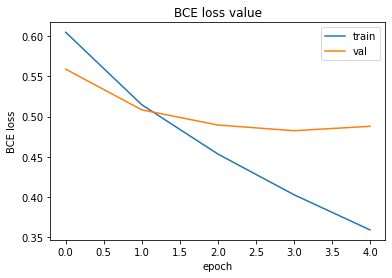

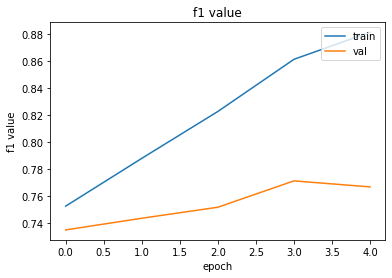

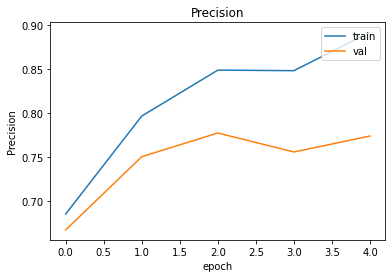

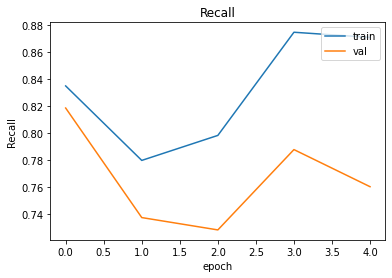

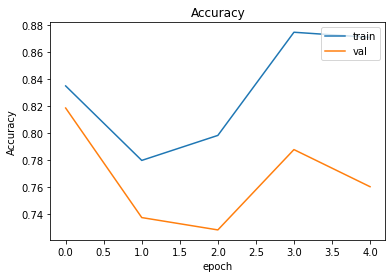

In [ ]:
model = CNN_with_pretrained2(len(word2id), 250, fasttext_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)
num_epochs = 5

losses, losses_eval, f1s, f1s_eval, pr, pr_eval, acc, acc_eval, rec, rec_eval = train_epochs(model, 
                                                                                             train_iterator, 
                                                                                             val_iterator, 
                                                                                             optimizer,
                                                                                             criterion,
                                                                                             num_epochs)
make_graphs(losses, losses_eval, 
                f1s, f1s_eval, 
                pr, pr_eval, 
                acc, acc_eval, 
                rec, rec_eval)

In [ ]:
add_to_table(losses_eval, pr_eval, rec_eval, acc_eval, f1s_eval, all_dfs)
pd.concat(all_dfs, axis=0)

,losses,precision,recall,accuracy,f1
0,0.493700,0.754757,0.782090,0.782090,0.767982
0,0.515575,0.763775,0.753040,0.753040,0.758115
0,0.567143,0.728616,0.671166,0.671166,0.698556
0,0.600492,0.699147,0.632695,0.632695,0.663658
0,0.492095,0.775303,0.747426,0.747426,0.760794
0,0.485133,0.765093,0.774003,0.774003,0.769184


losses, precision, f1 показывают лучшие рез-ты из всех экспериментов

recall немного меньше чем в 1м эксперименте

наверное этот вариант можно считать улучшением

# 2 архитектура

II. комбинация эмбеддингов и символьных признаков: 
У этой модели два входа, один для эмбеддингов слов (предобученных или обучаемых), 
из них берем max или mean, 
делаем вектор для предложения, 
поверх линейный слой - получаем вектор X. 
Другой вход сети для символьного представления слов 
(это обучаемый Embedding слой, 
 он будет брать на вход batch_size x symbols_len и сопоставлять 
 каждому символу в каждом слове один эмбеддинг). 
 
 Следующий слой сверточный, примените фильтры разных размеров. 
 
 Результаты агрегируются с помощью max pooling over time 
 и полученные векторы конкатенируются с вектором X.

Далее линейный слой + сигмоида, функция потерь BCELoss.

данные

In [33]:
vocab = Counter()
for text in tweets_data['text']:
    temp = preprocess(text)
    for word in temp:
        vocab.update(list(word))
print('всего уникальных символов:', len(vocab))

filtered_vocab = set()

for symbol in vocab:
    if vocab[symbol] > 5:
        filtered_vocab.add(symbol)
print('уникальных символов, втретившихся больше 5 раз:', len(filtered_vocab))

#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
symbol2id = {'PAD':0}

for symbol in filtered_vocab:
    symbol2id[symbol] = len(symbol2id)

#обратный словарь для того, чтобы раскодировать последовательность
id2symbol = {i:symbol for symbol, i in symbol2id.items()}
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

всего уникальных символов: 380
уникальных символов, втретившихся больше 5 раз: 163


device(type='cuda')

датасет

In [30]:
class TweetsDataset2(Dataset):

    def __init__(self, dataset, word2id, symbol2id, punctuation, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.punctuation = punctuation
        self.device = DEVICE

    def __len__(self):
        return self.length
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(self.punctuation) for token in tokens]
        return tokens

    def __getitem__(self, index): 
        sentence = self.dataset[index]
        preproced = self.preprocess(sentence)
        ids = torch.LongTensor([self.word2id[word] for word in preproced if word in self.word2id])
        symbol_ids = []
        for word in preproced:
            symbol_ids += [self.symbol2id[symbol] for symbol in word if symbol in self.symbol2id]
        symbol_ids = torch.LongTensor(symbol_ids)
        y = [self.target[index]]
        return ids, symbol_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, symbol_ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      padded_symbol_ids = pad_sequence(symbol_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return (padded_ids, padded_symbol_ids), y

In [31]:
train_dataset = TweetsDataset2(train_data, word2id, symbol2id, punctuation, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

val_dataset = TweetsDataset2(val_data, word2id, symbol2id, punctuation, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [32]:
class CNN_WordSymb(nn.Module):
    
    def __init__(self, vocab_size, symb_vocab_size, embedding_dim, symb_embedding_dim, weights):
        super().__init__()
        # предобученные эмбеддинги слов
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.emb2h = nn.Linear(in_features=embedding_dim, out_features=100)
        
        # обучаемый Embedding слой для символов
        self.embedding_symbol = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.symb_bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=2, padding='same') # 100 фильтров с окном 2
        self.symb_trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=80, kernel_size=3, padding='same') # 80 фильтров с окном 3
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2) 
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=280, out_features=1)
        self.out = nn.Sigmoid()


    def forward(self, mytuple):
        #batch_size x seq_len
        embedded = self.embedding(mytuple[0])
        mean_emb = torch.mean(embedded, dim=1)
        #batch_size x embdim
        vectorX = self.emb2h(mean_emb) #batch_size x 100

        symb_embedded = self.embedding_symbol(mytuple[1])
        #batch_size x seq_len x embedding_dim
        symb_embedded = symb_embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        symb_feature_map_bigrams = self.relu(self.symb_bigrams(symb_embedded))
        #batch_size x filter_count2 x seq_len* 
        symb_feature_map_trigrams = self.relu(self.symb_trigrams(symb_embedded))
        #batch_size x filter_count3 x seq_len*

        # полученные результаты конкатенируются друг с другом по глубине
        concat = torch.cat((symb_feature_map_bigrams, symb_feature_map_trigrams), 1)
        # batch _size x (filter_count2 + filter_count3) x seq_len*

        pooling_overtime = concat.max(2)[0] # max pooling over time
        # batch_size x (filter_count2 + filter_count3)

        concat2 = torch.cat((vectorX, pooling_overtime), 1)
        logits = self.hidden(concat2)
        logits = self.out(logits) # sigmoid 

        return logits


starting Epoch 0
Training...
Train loss: 0.7083831499604618
Train loss: 0.6796720900397369
Train loss: 0.6612499677217923
Train loss: 0.6452260840710976
Train loss: 0.6309940869780792

Evaluating on train...

Evaluating on test...

starting Epoch 1
Training...
Train loss: 0.5573163751293632
Train loss: 0.5399366932502692
Train loss: 0.5278838305519178
Train loss: 0.519457302719569
Train loss: 0.5107185434678505

Evaluating on train...

Evaluating on test...

starting Epoch 2
Training...
Train loss: 0.45984236545422497
Train loss: 0.45023011038268823
Train loss: 0.4418750462623743
Train loss: 0.43854034890373833
Train loss: 0.4357777503372609

Evaluating on train...

Evaluating on test...

starting Epoch 3
Training...
Train loss: 0.4039594154147541
Train loss: 0.3984988638456317
Train loss: 0.3963109085766169
Train loss: 0.3921203840550759
Train loss: 0.39111207476977644

Evaluating on train...

Evaluating on test...

starting Epoch 4
Training...
Train loss: 0.3701952222515555
Train lo

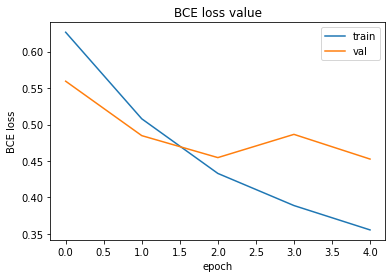

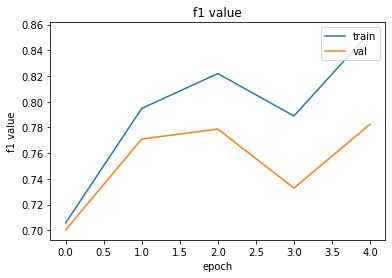

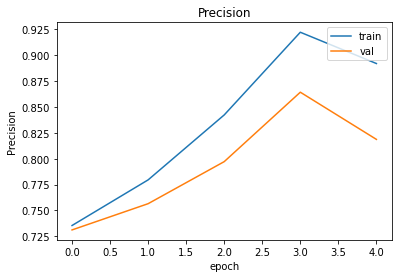

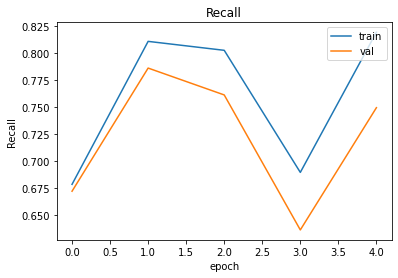

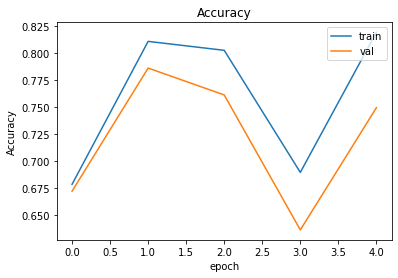

In [ ]:
model = CNN_WordSymb(len(word2id), len(symbol2id), 250, 10, fasttext_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


model = model.to(DEVICE)
criterion = criterion.to(DEVICE)
num_epochs = 5

losses, losses_eval, f1s, f1s_eval, pr, pr_eval, acc, acc_eval, rec, rec_eval = train_epochs(model, 
                                                                                             train_iterator, 
                                                                                             val_iterator, 
                                                                                             optimizer,
                                                                                             criterion,
                                                                                             num_epochs)
make_graphs(losses, losses_eval, 
                f1s, f1s_eval, 
                pr, pr_eval, 
                acc, acc_eval, 
                rec, rec_eval)

In [ ]:
sectable = []
add_to_table(losses_eval, pr_eval, rec_eval, acc_eval, f1s_eval, sectable)
sectable[0].head()
# pd.concat(sectable, axis=0)

,losses,precision,recall,accuracy,f1
0,0.469563,0.841448,0.693039,0.693039,0.757619


увеличение кол-ва эпох


starting Epoch 0
Training...
Train loss: 0.7028195928124821
Train loss: 0.6788614089938177
Train loss: 0.663607120513916
Train loss: 0.648186597463896
Train loss: 0.634705421225778

Evaluating on train...

Evaluating on test...

starting Epoch 1
Training...
Train loss: 0.5614640590022592
Train loss: 0.5433261623417122
Train loss: 0.5308251925385915
Train loss: 0.5217599345625733
Train loss: 0.5150734595526224

Evaluating on train...

Evaluating on test...

starting Epoch 2
Training...
Train loss: 0.4643986488089842
Train loss: 0.4531203443589418
Train loss: 0.44829366040917545
Train loss: 0.44466703058146745
Train loss: 0.4416874794439338

Evaluating on train...

Evaluating on test...

starting Epoch 3
Training...
Train loss: 0.41081057225956635
Train loss: 0.4020798854205919
Train loss: 0.3992442866930595
Train loss: 0.39818696666964526
Train loss: 0.3959540019090148

Evaluating on train...

Evaluating on test...

starting Epoch 4
Training...
Train loss: 0.3703448518234141
Train loss

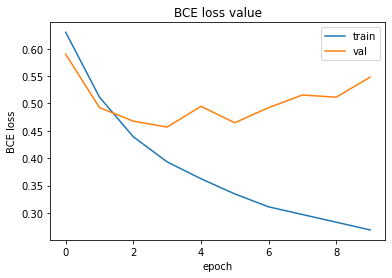

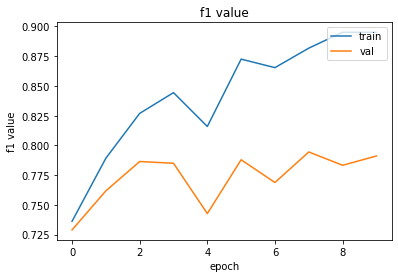

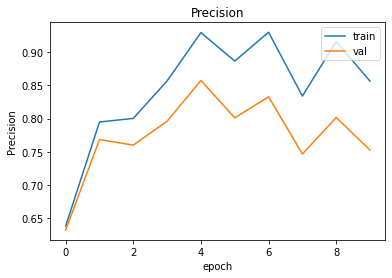

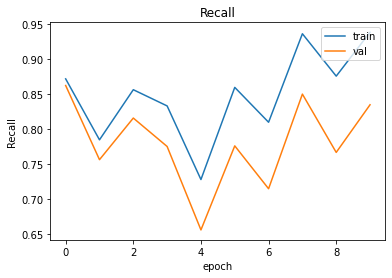

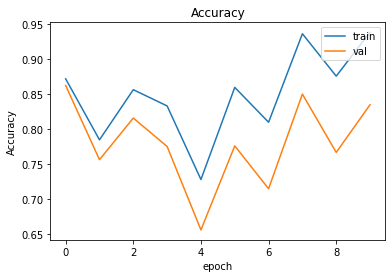

In [ ]:
model = CNN_WordSymb(len(word2id), len(symbol2id), 250, 10, fasttext_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


model = model.to(DEVICE)
criterion = criterion.to(DEVICE)
num_epochs = 10

losses, losses_eval, f1s, f1s_eval, pr, pr_eval, acc, acc_eval, rec, rec_eval = train_epochs(model, 
                                                                                             train_iterator, 
                                                                                             val_iterator, 
                                                                                             optimizer,
                                                                                             criterion,
                                                                                             num_epochs)
make_graphs(losses, losses_eval, 
                f1s, f1s_eval, 
                pr, pr_eval, 
                acc, acc_eval, 
                rec, rec_eval)

хотя losses немного увеличились, в целом метрика качества f1 стала лучше

на графике лосс функции видно, что модель сильно переобучается, поэтому в следуещем эксперименте попробую это исправить добавлением дропаута

In [ ]:
add_to_table(losses_eval, pr_eval, rec_eval, acc_eval, f1s_eval, sectable)
pd.concat(sectable, axis=0)

,losses,precision,recall,accuracy,f1
0,0.469563,0.841448,0.693039,0.693039,0.757619
0,0.529709,0.776989,0.800157,0.800157,0.787176


добавление дропаута

In [36]:
class CNN_WordSymb_drop(nn.Module):
    
    def __init__(self, vocab_size, symb_vocab_size, embedding_dim, symb_embedding_dim, weights):
        super().__init__()
        # предобученные эмбеддинги слов
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.emb2h = nn.Linear(in_features=embedding_dim, out_features=100)

        # обучаемый Embedding слой для символов
        self.embedding_symbol = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.symb_bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=2, padding='same') # 100 фильтров с окном 2
        self.symb_trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=80, kernel_size=3, padding='same') # 80 фильтров с окном 3
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2) 
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=280, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, mytuple):
        embedded = self.embedding(mytuple[0])
        mean_emb = torch.mean(embedded, dim=1)
        vectorX = self.emb2h(mean_emb)

        symb_embedded = self.embedding_symbol(mytuple[1])
        symb_embedded = symb_embedded.transpose(1,2)
        
        symb_feature_map_bigrams = self.dropout(self.relu(self.symb_bigrams(symb_embedded)))
        symb_feature_map_trigrams = self.dropout(self.relu(self.symb_trigrams(symb_embedded)))

        # полученные результаты конкатенируются друг с другом по глубине
        concat = torch.cat((symb_feature_map_bigrams, symb_feature_map_trigrams), 1)

        pooling_overtime = concat.max(2)[0] # max pooling over time
        concat2 = torch.cat((vectorX, pooling_overtime), 1)
        logits = self.hidden(concat2)
        logits = self.out(logits) # sigmoid 

        return logits

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  import sys



starting Epoch 0
Training...


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Train loss: 0.7117388844490051
Train loss: 0.6828390541283981
Train loss: 0.6657150192902639
Train loss: 0.6518351216968015
Train loss: 0.6382348770382761

Evaluating on train...

Evaluating on test...

starting Epoch 1
Training...
Train loss: 0.5727395467898425
Train loss: 0.5536219261694646
Train loss: 0.5412432482609382
Train loss: 0.5306589093139703
Train loss: 0.5221811944040758

Evaluating on train...

Evaluating on test...

starting Epoch 2
Training...
Train loss: 0.47101540775860057
Train loss: 0.4650661522063656
Train loss: 0.45788507707990134
Train loss: 0.45291845789916224
Train loss: 0.44975472935314836

Evaluating on train...

Evaluating on test...

starting Epoch 3
Training...
Train loss: 0.4119822961442611
Train loss: 0.4048838179180588
Train loss: 0.4050010253603642
Train loss: 0.4049085144945186
Train loss: 0.402638982938624

Evaluating on train...

Evaluating on test...

starting Epoch 4
Training...
Train loss: 0.37618807484121886
Train loss: 0.3734266464261041
Train 

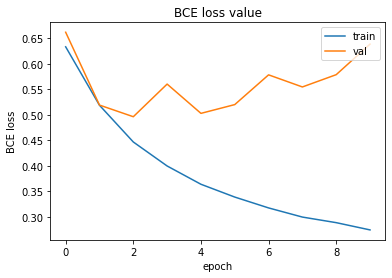

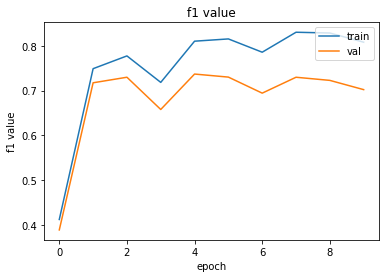

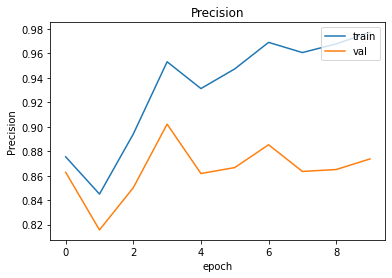

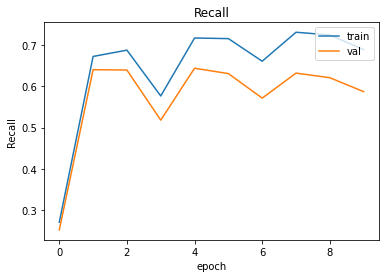

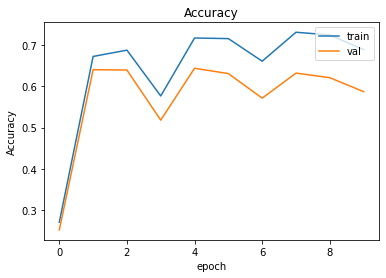

In [37]:
model = CNN_WordSymb_drop(len(word2id), len(symbol2id), 250, 10, fasttext_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


model = model.to(DEVICE)
criterion = criterion.to(DEVICE)
num_epochs = 10

losses, losses_eval, f1s, f1s_eval, pr, pr_eval, acc, acc_eval, rec, rec_eval = train_epochs(model, 
                                                                                             train_iterator, 
                                                                                             val_iterator, 
                                                                                             optimizer,
                                                                                             criterion,
                                                                                             num_epochs)
make_graphs(losses, losses_eval, 
                f1s, f1s_eval, 
                pr, pr_eval, 
                acc, acc_eval, 
                rec, rec_eval)

In [38]:
thirdtable = []

In [39]:
add_to_table(losses_eval, pr_eval, rec_eval, acc_eval, f1s_eval, thirdtable)
print(thirdtable[0])


     losses  precision    recall  accuracy        f1
0  0.608943    0.86935  0.603998  0.603998  0.712291



| losses      | precision   | recall      | f1   |
| ----------- | ----------- | ----------- | ----------- |
| 0.469563      | 	0.841448       | 0.693039    | 0.757619        |
| 0.529709       | 0.776989       | 0.800157    | 0.787176        |








по сравнению с предыдущими экспериментами стало хуже, но сильно повысилась precision

посмотрю, что будет если вообще не предобрабатывать данные, смайлики и пунктуация (like "!!!" или "(((" ) очевидно могут сильно помочь

In [34]:
class TweetsDataset3(Dataset):

    def __init__(self, dataset, word2id, symbol2id, punctuation, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.punctuation = punctuation
        self.device = DEVICE

    def __len__(self):
        return self.length
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(self.punctuation) for token in tokens]
        return tokens

    def __getitem__(self, index): 
        sentence = self.dataset[index] 
        preproced = sentence # self.preprocess(sentence)
        ids = torch.LongTensor([self.word2id[word] for word in preproced if word in self.word2id])
        symbol_ids = []
        for word in preproced:
            symbol_ids += [self.symbol2id[symbol] for symbol in word if symbol in self.symbol2id]
        symbol_ids = torch.LongTensor(symbol_ids)
        y = [self.target[index]]
        return ids, symbol_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, symbol_ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      padded_symbol_ids = pad_sequence(symbol_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return (padded_ids, padded_symbol_ids), y

In [35]:
train_dataset = TweetsDataset3(train_data, word2id, symbol2id, punctuation, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

val_dataset = TweetsDataset3(val_data, word2id, symbol2id, punctuation, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  import sys



starting Epoch 0
Training...


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Train loss: 0.7142969194580527
Train loss: 0.6490593708079794
Train loss: 0.5824932146530885
Train loss: 0.516980823853033
Train loss: 0.46077329365686437

Evaluating on train...

Evaluating on test...

starting Epoch 1
Training...
Train loss: 0.18707027768387513
Train loss: 0.16711685277413632
Train loss: 0.15046533204328555
Train loss: 0.1370212863460719
Train loss: 0.1252472848984702

Evaluating on train...

Evaluating on test...

starting Epoch 2
Training...
Train loss: 0.06532510501496933
Train loss: 0.059546295067538384
Train loss: 0.05533096416351887
Train loss: 0.051524652945373554
Train loss: 0.04840420485185138

Evaluating on train...

Evaluating on test...

starting Epoch 3
Training...
Train loss: 0.03320716294076513
Train loss: 0.030998236270270485
Train loss: 0.030025270552589342
Train loss: 0.02942239808039271
Train loss: 0.028544243200328844

Evaluating on train...

Evaluating on test...

starting Epoch 4
Training...
Train loss: 0.023992598138968733
Train loss: 0.0222165

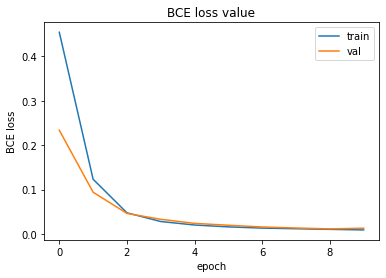

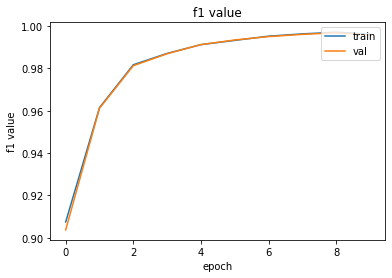

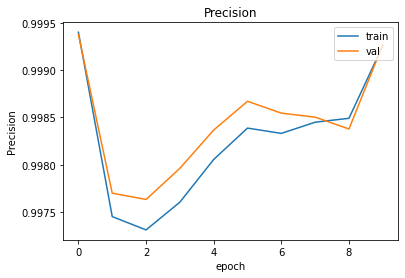

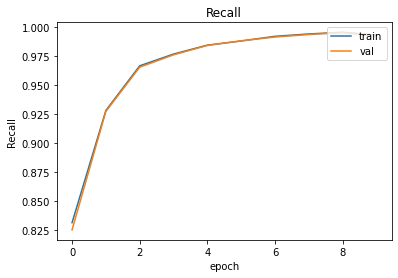

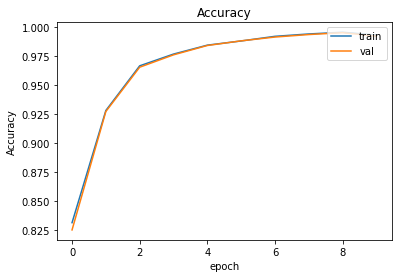

In [37]:
model = CNN_WordSymb_drop(len(word2id), len(symbol2id), 250, 10, fasttext_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


model = model.to(DEVICE)
criterion = criterion.to(DEVICE)
num_epochs = 10

losses, losses_eval, f1s, f1s_eval, pr, pr_eval, acc, acc_eval, rec, rec_eval = train_epochs(model, 
                                                                                             train_iterator, 
                                                                                             val_iterator, 
                                                                                             optimizer,
                                                                                             criterion,
                                                                                             num_epochs)
make_graphs(losses, losses_eval, 
                f1s, f1s_eval, 
                pr, pr_eval, 
                acc, acc_eval, 
                rec, rec_eval)

In [38]:
table4 = []

In [39]:
add_to_table(losses_eval, pr_eval, rec_eval, acc_eval, f1s_eval, table4)
print(table4[0])

     losses  precision    recall  accuracy        f1
0  0.012546   0.998823  0.993816  0.993816  0.996308


как и ожидалось на непредобработанном датасете качество очень высокое, почти 100 процентов правильный результат. вывод - в датасете заложен баес в виде смайликов и оценочной пунктуации